In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/tviel/work/kaggle_rsna_lumbar_spine/src


/home/tviel/.local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
import os
import cv2
import json
import glob
import torch
import pydicom
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F

from collections import Counter
from tqdm.notebook import tqdm


pd.set_option('display.width', 5000)
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_columns', 100)

In [4]:
from params import *


from data.dataset import *
from data.transforms import *
from data.preparation import *
from data.processing import read_series_metadata
from data.sagittal_to_axial import get_axial_coords

from model_zoo.models import define_model
from util.torch import load_model_weights
from util.plots import *

from inference.lvl1 import Config, predict

In [5]:
# prepare_data_crop(DATA_PATH, crop_folder="../input/crops_0.15_2/")

In [6]:
# df = prepare_data_nfn(DATA_PATH, crop_folder="../input/crops_0.15_2/")
# df = df[df['side'] == 'Left']
# df_preds_coords = pd.read_csv('../output/seg_sag_coords.csv')
# df = df.merge(df_preds_coords, how="left")
# delta = df.apply(lambda x: x.left - x.coords[0] if x.side == "Left" else x.right - x.coords[0], axis=1)

## Sagittal

### Inference

In [7]:
EXP_FOLDER = "../logs/2024-08-28/13/"  # coatnet_rmlp_2_rw_384 50 ep new folds
EXP_FOLDER = "../logs/2024-08-28/24/"  # coatnet_rmlp_2_rw_384 aug 50 ep new folds
EXP_FOLDER = "../logs/2024-08-29/0/"  # coatnet_rmlp_2_rw_384 aug 50 ep new folds
FOLD = 0

In [8]:
# coords = pd.read_csv(DATA_PATH + 'train_label_coordinates_v0.csv')
# coords = coords[coords['condition'] == "Spinal Canal Stenosis"].sort_values(["study_id", "series_id", 'level'])
# coords = coords.groupby(["study_id", "series_id"]).agg(list).reset_index()
# coords = coords[coords['level'].apply(len) != 5]

In [9]:
# df_y = pd.read_csv(DATA_PATH + "train.csv")
# df_y[df_y.isna().values[:, :15].sum(1) > 0]
# os.listdir('../input/train_images/2492114990/')
# df_gt = prepare_data_scs(explode=False)
# df_gt = df_gt[df_gt["level"].apply(lambda x: 0 if isinstance(x, float) else len(x)) != 5]
# df_gt.head(1)

# for i, row in df_gt.iterrows():
#     try:
#         missing = [j for j, r in enumerate(LEVELS)  if r not in row.level]
#     except:
#         missing = range(5)

#     for i in missing:
#         print("Missing disk", LEVELS[i], " - target", row[CLASSES_SCS[i]])
#     print()

#     # break

In [10]:
config = Config(json.load(open(EXP_FOLDER + "config.json", "r")))

df = prepare_coords_data(config.coords_folder, use_ext=config.use_ext)

folds = pd.read_csv(config.folds_file)
df = df.merge(folds, how="left")
df['fold'] = df['fold'].fillna(-1)

In [11]:
# # models_sag = []
# for fold in range(4):
#     model = define_model(
#         config.name,
#         drop_rate=config.drop_rate,
#         drop_path_rate=config.drop_path_rate,
#         pooling=config.pooling,
#         num_classes=config.num_classes,
#         num_classes_aux=config.num_classes_aux,
#         n_channels=config.n_channels,
#         reduce_stride=config.reduce_stride,
#         pretrained=False,
#     )
#     model = model.cuda().eval()

#     weights = EXP_FOLDER + f"{config.name}_{fold}.pt"
#     try:
#         model = load_model_weights(model, weights, verbose=config.local_rank == 0)
#     except FileNotFoundError:
#         continue
#     # models_sag.append(model)

#     df_val = df[df['fold'] == fold].reset_index(drop=True)
#     dataset = CoordsDataset(df_val, transforms=get_transfos(augment=False, resize=config.resize, use_keypoints=True))

#     preds, _ = predict(model, dataset, config.loss_config, batch_size=32, use_fp16=True)

#     np.save(EXP_FOLDER + f"pred_inf_{fold}.npy", preds)

### Eval

In [12]:
# cc = pd.read_csv('../input/train_label_coordinates.csv')

# cc = cc.merge(
#     cc[["series_id", "level"]].groupby("series_id").count().reset_index(),
#     how="left",
#     on="series_id",
#     suffixes=("", "_count"),
# )

# dfg = (
#     cc[(cc.condition.isin(["Right Neural Foraminal Narrowing", "Left Neural Foraminal Narrowing"])) & ~(cc.level_count.isin([10]))]
#     .groupby(["study_id", "series_id"])
#     .agg(list)
#     .reset_index()
# )
# dfg.shape

# # dfg = (
# #     cc[(cc.condition == "Spinal Canal Stenosis") & (cc.level_count != 5)]
# #     .sort_values("level")
# #     .groupby(["study_id", "series_id"])
# #     .agg(list)
# #     .reset_index()
# # )
# # dfg.shape

In [13]:
# TO_FIX = [
#     # 1468566581,
#     # 2185202709,
#     # 716946645,
#     # 3123114360,
#     # 2143604834,
#     # 1540250849,
#     # 2943022937,
#     # 425681838,
#     # 1638921810,
#     # 4089223112,
#     # 648725109,
#     # 2177693773,
#     # 2929396535,
#     # 4245678886,
#     # 2538968579,
# ]

# def shift_disk_up():
#     df = pd.read_csv('../input/train_label_coordinates.csv')

#     for series in TO_FIX:
#         df_fixes = df.loc[df['series_id'] == series].sort_values('level').reset_index(drop=True)
#         df = df[df['series_id'] != series].reset_index(drop=True)

#         for _, df_fix  in df_fixes.groupby('condition'):
#             df_fix['level'] = df_fix['level'].map({'L1/L2': "L2/L3", 'L2/L3': "L3/L4", 'L3/L4': "L4/L5", 'L4/L5': "L5/S1"})
#             df_fix = df_fix.dropna(axis=0)
#             df = pd.concat([df, df_fix], ignore_index=True)

#     df.to_csv('../input/train_label_coordinates_shift.csv')

# # shift_disk_up()

In [14]:
PLOT = False

In [15]:
df_gt = prepare_data()
df_sev = prepare_data_crop(DATA_PATH)
df_spinenet = pd.read_csv('../output/spinenet_kps.csv')

In [16]:
# STUDIES = df_gt[df_gt['series_id'].isin(TO_FIX)].study_id.values

In [17]:
def fix_predictions(p, y, verbose=0):
    d = np.abs(p - y) * 100
    d = d[y.sum(-1) > 0].mean()

    if y.min() > 0 and d > 1:
        return y

    delta = (np.random.random() - 0.5) / 100
    
    # Shift down
    p_down = p[1:]
    y_down = y[:-1]
    d_down = np.abs(p_down - y_down) * 100
    d_down = d_down[y_down.sum(-1) > 0].mean()

    # Shift up
    p_up = p[:-1]
    y_up = y[1:]
    d_up = np.abs(p_up - y_up) * 100
    d_up = d_up[y_up.sum(-1) > 0].mean()

    if d_up < d:  # shift up
        if verbose:
            print('Shift up')
        if y[0].sum() > 0:
            fix = y[0] + delta
        else:
            fix = p[0] + np.array([0.03, -0.09])
        return np.vstack([fix, p_up])

    elif d_down < d:  # shift down
        if verbose:
            print('Shift down')
        if y[-1].sum() > 0:
            fix = y[-1] + delta
        else:
            fix = p[-1] + np.array([0.04, 0.09])
        return np.vstack([p_down, fix])

    else:
        return p


In [18]:
ds = []
df_ = prepare_data()

for fold in range(4):
    preds = np.load(EXP_FOLDER + f"pred_inf_{fold}.npy")
    df_val = df[df['fold'] == fold].reset_index(drop=True)
    
    dataset = CoordsDataset(df_val, transforms=get_transfos(augment=False, use_keypoints=True))

    for idx in tqdm(range(len(dataset))):
        study = df_val['study_id'][idx]
        series = df_val['series_id'][idx]

        # if df_val['series_description'][idx] != "Sagittal T2/STIR":
        #     continue

        # if series in TO_FIX:
        #     continue
        # if not study in STUDIES:
        #     continue

        img, y, _ = dataset[idx]
        labels = np.vstack(df_sev[df_sev['series_id'] == series].sort_values('level')['target'].values)

        gt = df_gt[df_gt['series_id'] == series]
        imgs = np.load(f'../input/npy2/{study}_{series}.npy')

        # print(gt['coords'].values[0][:, 0])
        # frame = int(np.round(gt['coords'].values[0][:, 0].mean()))
        frame = len(imgs) // 2
        # frame = len(imgs) // 4
        # frame = int(gt['coords'].values[0][-1, 0])

        img = imgs[frame]
        img = (img - img.min()) / (img.max() - img.min())

        try:
            spinenet_coords = df_spinenet[df_spinenet['series_id'] == series]
            spinenet_coords = spinenet_coords.values[len(spinenet_coords)  // 2, -10:].reshape(2, 5).T
            spinenet_coords[:, 0] /= img.shape[1]
            spinenet_coords[:, 0] /= img.shape[0]
            # p = spinenet_coords.copy()
            # p[:, 0] /= img.shape[1]
            # p[:, 1] /= img.shape[0]
        except:
            spinenet_coords = None

        p_ = preds[idx].reshape(-1, 2)
        p = preds[idx].reshape(-1, 2)

        # p = fix_predictions(p, y.numpy())
        p_ = p.copy()

        d = np.abs(p - y.numpy()) * 100
        d = d[y.sum(-1) > 0].mean()
        ds.append(d)

        if PLOT:
            if d > 3:
                y = y[y.sum(-1) > 0]
                # if len(y) == 5:
                #     continue

                print(study, series)
                print('SCS / L-NFN / R-NFN / L-SS / R-SS')
                print(labels)

                # cv2.imwrite(f'../output/fix/{study}_{series}.png', (img * 255).astype(np.uint8))

                plt.figure(figsize=(8, 8))
                plt.imshow(img, cmap="gray")
                plt.scatter(y[:, 0] * img.shape[1], y[:, 1] * img.shape[0], marker="x", label="truth")
                plt.scatter(p_[:, 0] * img.shape[1], p_[:, 1] * img.shape[0], marker="x", label="pred")
                if spinenet_coords is not None:
                    plt.scatter(spinenet_coords[:, 0], spinenet_coords[:, 1], marker="x", label="spinenet")
                plt.title(f'Dist = {d:.2f} - study {study} - series {series}')
                plt.axis(False)
                plt.legend()
                plt.show()

                print(p_[:, 0] * img.shape[1], p_[:, 1] * img.shape[0])

            # if idx > 50:
                # break
    # if PLOT:
    break


  0%|          | 0/991 [00:00<?, ?it/s]

In [19]:
print('Images with error > 5%:', (np.array(ds) > 5).sum())
print('Images with error > 4%:', (np.array(ds) > 4).sum())
print('Images with error > 3%:', (np.array(ds) > 3).sum())

Images with error > 5%: 6
Images with error > 4%: 9
Images with error > 3%: 21


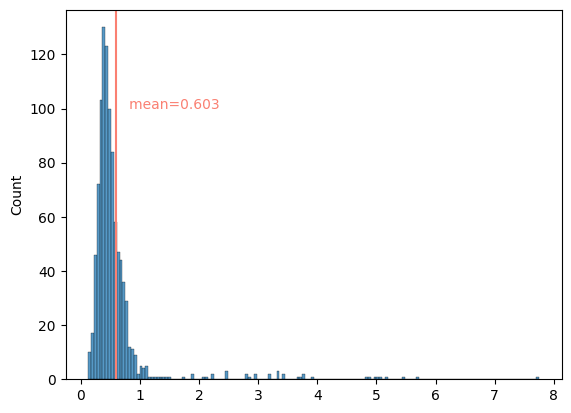

In [20]:
sns.histplot(ds)
plt.axvline(np.mean(ds), c="salmon")
plt.text(np.mean(ds), 100, f"   mean={np.mean(ds):.3f}", color="salmon")
plt.show()

### Crop

In [21]:
DELTA = 0.1

SAVE = True
PLOT = False

SAVE_FOLDER = f"../input/coords_crops_{DELTA}_2/"
os.makedirs(SAVE_FOLDER, exist_ok=True)

In [22]:
# for fold in range(4):
#     pred_val = np.load(EXP_FOLDER + f"pred_inf_{fold}.npy")
#     df_val = df[df['fold'] == fold].reset_index(drop=True)

#     for idx in tqdm(range(len(df_val))):
#         study_series = df_val["img_path"][idx].split('/')[-1][:-4]
#         imgs_path = DATA_PATH + "npy2/" + study_series + ".npy"      ###### NPY2 ??
#         imgs = np.load(imgs_path)
#         img = imgs[0]

#         # try:
#         #     series = df_val["series_id"][idx]
#         #     spinenet_coords = df_spinenet[df_spinenet['series_id'] == series]
#         #     spinenet_coords = spinenet_coords.values[len(spinenet_coords)  // 2, -10:].reshape(2, 5).T
#         #     spinenet_coords[:, 0] /= img.shape[1]
#         #     spinenet_coords[:, 1] /= img.shape[0]
#         #     preds = spinenet_coords.copy()
#         # except IndexError:
#         #     print('No Spinenet coords found')
#         preds = pred_val[idx].reshape(-1, 2)
#         # preds = fix_predictions(preds, df_val["target_rel"][idx], verbose=1)

#         assert preds.min() >= 0
#         assert preds.max() <= 1

#         crops = np.concatenate([preds, preds], -1)
#         crops[:, [0, 1]] -= DELTA
#         crops[:, [2, 3]] += DELTA
#         crops = crops.clip(0, 1)
#         crops[:, [0, 2]] *= imgs.shape[2]
#         crops[:, [1, 3]] *= imgs.shape[1]
#         crops = crops.astype(int)

#         # print(df_val["series_id"][idx])

#         if SAVE:
#             for i, (x0, y0, x1, y1) in enumerate(crops):
#                 crop = imgs[:, y0: y1, x0: x1].copy()
#                 assert crop.shape[2] > 1 and crop.shape[1] > 1
#                 np.save(SAVE_FOLDER + f'{study_series}_{LEVELS_[i]}.npy', crop)

#                 # cc = np.load(SAVE_FOLDER + study_series + "_" + LEVELS_[i] + ".npy")
#                 # plt.imshow(cc[len(cc) // 2], cmap="gray")
#                 # plt.show()

#         if PLOT:
#             preds[:, 0] *= imgs.shape[2]
#             preds[:, 1] *= imgs.shape[1]

#             plt.figure(figsize=(8, 8))
#             plt.imshow(imgs[len(imgs) // 2], cmap="gray")
#             plt.scatter(preds[:, 0], preds[:, 1], marker="x", label="center")
#             # plt.scatter(crops[:, 0], crops[:, 1], marker="x", label="top-left")
#             # plt.scatter(crops[:, 2], crops[:, 3], marker="x", label="bot-right")
#             plt.title(study_series)
#             plt.axis(False)
#             plt.legend()
#             plt.show()


#             break

## Axial

In [23]:
from data.sagittal_to_axial import *

In [24]:
ref_studies = [
    # 113758629,
    # 13317052, 60612428, 74294498, 142991438, 
    # 168833126, 189360935, 58813022, 1115952008, 959290081,
    2388577668  # bugged
]

PLOT = False
SAVE = True

SIZE = 0.1
SAVE_FOLDER = f"../input/crops_ax_{SIZE}/"

os.makedirs(SAVE_FOLDER, exist_ok=True)

In [25]:
EXP_FOLDER_AX = "../logs/2024-09-02/33/"

config = Config(json.load(open(EXP_FOLDER_AX + "config.json", "r")))

models_ax = []
for fold in range(4):
    model = define_model(
        config.name,
        drop_rate=config.drop_rate,
        drop_path_rate=config.drop_path_rate,
        pooling=config.pooling,
        num_classes=config.num_classes,
        num_classes_aux=config.num_classes_aux,
        n_channels=config.n_channels,
        reduce_stride=config.reduce_stride,
        pretrained=False,
    )
    model = model.cuda().eval()

    weights = EXP_FOLDER_AX + f"{config.name}_{fold}.pt"
    model = load_model_weights(model, weights, verbose=config.local_rank == 0)
    models_ax.append(model)

    # break

KeyError: 'encoder.conv_stem.weight'

In [ ]:
df = prepare_coords_data()

folds = pd.read_csv(config.folds_file)
df = df.merge(folds, how="left")
df['fold'] = df['fold'].fillna(-1)

In [ ]:
df_ = prepare_data()
df_coords = pd.read_csv(DATA_PATH + "train_label_coordinates.csv")
df_coords['side'] = df_coords['condition'].apply(lambda x: x.split()[0])

In [ ]:
coords = []
axial_coords = []
errors = []
pred_sag_coords = []

for fold in range(4):
    preds_coords = np.load(EXP_FOLDER + f"pred_val_{fold}.npy")
    df_val = df[df["fold"] == fold].reset_index(drop=True)

    for idx in tqdm(range(len(df_val))):
        # if idx < 20:
        #     continue
        
        study = df_val["study_id"][idx]
        series = df_val["series_id"][idx]

        df_s = df_[df_["study_id"] == study]
        series_ax = df_s[df_s["orient"] == "Axial"].series_id.values[0]

        # if not study in ref_studies:
        #     continue

        # Get axial projection
        p = preds_coords[idx].reshape(-1, 2)
        # p = fix_predictions(p, df_val["target_rel"][idx])

        img = cv2.imread(df_val["img_path"][idx])
        h, w, _ = img.shape

        world_point, assigned_level, closest_z, df_axial = get_axial_coords(
            study,
            series,
            series_ax,
            p.copy(),
            h,
            w,
            "../input/train_images/",
        )

        if closest_z.max() == 0:  # Fix
            world_point[:, -1] -= (world_point[:, -1].mean() - df_axial.projection.mean())
            world_point, assigned_level, closest_z, df_axial = get_axial_coords(
                study,
                series,
                series_ax,
                p.copy(),
                h,
                w,
                "../input/train_images/",
                world_point=world_point
            )

        # Evaluate
        series_ax = df_axial["series_id"].values[0]
        df_gt = df_coords[df_coords["series_id"] == series_ax].reset_index(drop=True)
        df_gt = df_gt[["instance_number", "level", "x", "y"]].groupby("level").mean().sort_index()
        gt = df_gt["instance_number"].values.flatten()
        preds = df_axial["instance_number"].values[closest_z]

        if len(df_gt) == 5:
            mae = np.abs(gt - preds).mean()
        else:
            mae = 0

        # Locate disk
        imgs = np.load(f'../input/npy2/{study}_{series_ax}.npy')
        imgs_sag = np.load(f'../input/npy2/{study}_{series}.npy')

        with torch.no_grad():
            x = torch.tensor(imgs[closest_z].astype(np.float32)).cuda()

            min_ = x.amin((-1, -2), keepdim=True)
            max_ = x.amax((-1, -2), keepdim=True)
            x = (x - min_) / (max_ - min_)
            x =  F.interpolate(
                x.unsqueeze(1).repeat(1, 3, 1, 1),
                config.resize,
                mode="bilinear",
            )

            preds_ax = models_ax[fold](x)[0].sigmoid().detach().cpu().numpy().reshape(x.size(0), 2, 2)

        preds_ax[:, :, 0] *= imgs.shape[2]
        preds_ax[:, :, 1] *= imgs.shape[1]

        # GT
        df_lvl = df_coords[df_coords["series_id"] == series_ax].reset_index(drop=True)

        gts = np.zeros((5, 2, 2))
        for i in range(len(LEVELS)):
            df_lvl__ = df_lvl[df_lvl["level"] == LEVELS[i]]
            for j, s in enumerate(["Left", "Right"]):
                df_lvl_ = df_lvl__[df_lvl__['side'] == s]
                if len(df_lvl_):
                    gts[i, j] = np.array([df_lvl_['x'].values[0], df_lvl_["y"].values[0]])

        preds_ax = np.where(gts > 0, gts, preds_ax)  # FIX
        
        # Crop
        crop_imgs = []
        pts, closest_zs_ax = [], []
        for i in range(5):
            f = closest_z[i]
            fs = max(closest_z[i] - 3, 0)
            fe = min(closest_z[i] + 3, len(imgs))

            xc, yc = preds_ax[i].mean(0).astype(int)

            dx, dy = int(imgs.shape[2] * SIZE), int(imgs.shape[1] * SIZE)
            x0, x1 = max(xc - dx, 0), min(xc + dx, imgs.shape[2])
            y0, y1 = max(yc - dy, 0), min(yc + dy, imgs.shape[1])

            d = SIZE // 2
            crop = imgs[fs: fe, y0: y1, x0: x1]
            crop_imgs.append(crop[len(crop) // 2])

            if SAVE:
                np.save(SAVE_FOLDER + f"{study}_{series_ax}_{LEVELS_[i]}.npy", crop.copy())
                np.save(SAVE_FOLDER + f"{study}_{series}_{LEVELS_[i]}.npy", crop.copy())

            h_ax, w_ax = imgs.shape[1:]

            # world_point_ax, assigned_level_ax, closest_z_ax, df_sagittal = get_sagittal_coords(
            #     study,
            #     series,
            #     series_ax,
            #     preds_ax[i].copy(),
            #     f,
            #     1,
            #     1,
            #     "../input/train_images/",
            # )
            # pts.append(world_point_ax)
            # # print(f'Disk {LEVELS[i]} - closest {closest_z_ax}')
            # closest_zs_ax.append(closest_z_ax)

        # closest_zs_ax = np.array(closest_zs_ax)
        # left_frame = int(np.median(closest_zs_ax[:, 0]))
        # right_frame = int(np.median(closest_zs_ax[:, 1]))

        # df_coords_gt = df_coords[df_coords['study_id'] == study]
        # gt_l = int(np.median(df_coords_gt[df_coords_gt['side'] == "Left"]['instance_number'].values))
        # gt_r = int(np.median(df_coords_gt[df_coords_gt['side'] == "Right"]['instance_number'].values))

        # error_l = df_sagittal["instance_number"][left_frame] - gt_l
        # error_r = df_sagittal["instance_number"][right_frame] - gt_r

        # errors.append([error_l, error_r])

        # pred_sag_coords.append({
        #     "study_id": study,
        #     "series_id": series,
        #     "left": left_frame,
        #     "right": right_frame,
        # })

        # Plot
        if PLOT:  #  and (np.abs(error_l) > 5):  # or not (idx % 500):
            # display(df_sagittal)
            # print(f'Left - pred {left_frame} - truth {gt_l}')
            # print(f'Right - pred {right_frame} - truth {gt_r}')

            # plot_coords(
            #     np.concatenate(pts),
            #     assigned_level_ax,
            #     closest_z_ax, # np.concatenate(closest_zs_ax),
            #     h_ax,
            #     w_ax,
            #     df_sagittal,
            #     title=f"Study {study} - Series {series}",
            #     orient="axial",
            # )

            # # display(df_gt)
            # plot_coords(
            #     world_point,
            #     assigned_level,
            #     closest_z,
            #     h,
            #     w,
            #     df_axial,
            #     title=f"Study {study} - Series {series_ax}",
            # )

        
            # plt.figure(figsize=(20, 5))
            # plt.subplot(1, 4, 1)
            # plt.imshow(imgs_sag[left_frame], cmap="gray")
            # plt.title('Pred Left')
            # plt.subplot(1, 4, 2)
            # plt.imshow(imgs_sag[right_frame], cmap="gray")
            # plt.title('Pred Right')
            # plt.subplot(1, 4, 3)
            # try:
            #     plt.imshow(imgs_sag[df_sagittal["instance_number"].values.tolist().index(gt_l)], cmap="gray")
            #     plt.title('GT Left')
            #     plt.subplot(1, 4, 4)
            #     plt.imshow(imgs_sag[df_sagittal["instance_number"].values.tolist().index(gt_r)], cmap="gray")
            #     plt.title('GT Right')
            # except:
            #     pass
            # plt.show()
            
            # Ax coords preds
            plt.figure(figsize=(25, 5))
            for i in range(5):
                plt.subplot(1, 5, i + 1)

                img = imgs[closest_z[i]]

                plt.scatter(preds_ax[i, :, 0], preds_ax[i, :, 1], label="pred")
                plt.scatter(gts[i, :, 0], gts[i, :, 1], label="truth", marker="x")

                plt.imshow(img, cmap="gray")
                plt.legend()
                plt.axis(False)
                plt.title(str(df_axial["instance_number"][closest_z[i]]))
            plt.show()

            # Crops
            plt.figure(figsize=(25, 5))
            for i in range(5):
                plt.subplot(1, 5, i + 1)
                plt.imshow(crop_imgs[i], cmap="gray")
            plt.show()
            
            # if PLOT and idx >= 10:
            break
    # if PLOT:
        # if idx >= 100:
        #     break
    # break

In [ ]:
# df_preds_coords = pd.DataFrame(pred_sag_coords)
# df_preds_coords.to_csv('../output/preds_sag_coords.csv', index=False)

In [ ]:
df.head(1)

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(np.array(errors)[:, 0])
plt.subplot(1, 3, 2)
sns.histplot(np.array(errors)[:, 1])
plt.subplot(1, 3, 3)
sns.histplot(np.abs(np.array(errors)).flatten())
plt.show()

In [ ]:
# coords = []
# axial_coords = []

# for fold in range(4):
#     preds_coords = np.load(EXP_FOLDER + f"pred_val_{fold}.npy")
#     df_val = df[df["fold"] == fold].reset_index(drop=True)

#     for idx in tqdm(range(len(df_val))):
#         study = df_val["study_id"][idx]
#         series = df_val["series_id"][idx]

#         df_sagittal, _ = read_series_metadata(
#             study,
#             series,
#             "sagittal",
#             advanced_sorting=False,
#             return_imgs=False,
#         )
#         df_s = df_[df_["study_id"] == study]
#         series_ax = df_s[df_s["orient"] == "Axial"].series_id.values[0]

#         df_axial, _ = read_series_metadata(
#             study,
#             series_ax,
#             "axial",
#             return_imgs=False,
#         )

#         imgs_sag = np.load(f"../input/npy2/{study}_{series}.npy")
#         imgs_ax = np.load(f"../input/npy2/{study}_{series_ax}.npy")

#         sag_pos = np.array(df_sagittal["ImagePositionPatient"].values.tolist())
#         ax_pos = np.array(df_axial["ImagePositionPatient"].values.tolist())

#         top_left_hand_corner_sag_t2 = sag_pos[len(sag_pos) // 2]
#         spacing = df_sagittal["PixelSpacing"].values[0]
#         sag_y_axis_to_pixel_space = [
#             top_left_hand_corner_sag_t2[2] - spacing[1] * i for i in range(imgs_sag.shape[1])
#         ]

#         sag_y_coord_to_axial_slice = {}
#         for i, ax_t2_pos in enumerate(ax_pos):
#             diffs = np.abs(np.asarray(sag_y_axis_to_pixel_space) - ax_t2_pos[2])
#             sag_y_coord = np.argmin(diffs)
#             sag_y_coord_to_axial_slice[sag_y_coord] = i

#         plt.figure(figsize=(10, 5))
#         plt.subplot(1, 2, 1)
#         plt.imshow(imgs_sag[len(imgs_sag) // 2], cmap="gray")
#         for k in [*sag_y_coord_to_axial_slice]:
#             plt.axhline(y=k, color="red", linestyle="--", alpha=0.5)
#         plt.title(f'{study} {series_ax} - Sagittal to Axial')
#         plt.axis(False)

#         top_left_hand_corner_ax_t2 = ax_pos[len(ax_pos) // 2]
#         spacing = df_axial["PixelSpacing"].values[0]
#         ax_x_axis_to_pixel_space = [
#             top_left_hand_corner_ax_t2[0] + spacing[0] * i
#             for i in range(imgs_ax.shape[2])
#         ]

#         ax_x_coord_to_sag_slice = {}
#         for i, sag_t2_pos in enumerate(sag_pos):
#             diffs = np.abs(np.asarray(ax_x_axis_to_pixel_space) - sag_t2_pos[0])
#             ax_x_coord = np.argmin(diffs)
#             ax_x_coord_to_sag_slice[ax_x_coord] = i

#         plt.subplot(1, 2, 2)
#         img_ax = imgs_ax[len(imgs_ax) // 2]
#         plt.imshow(img_ax, cmap="gray")
#         for i, k in enumerate([*ax_x_coord_to_sag_slice]):
#             alpha = 0.5 if i == len(ax_x_coord_to_sag_slice) // 2 else 0.3
#             plt.axvline(x=k, color="red", linestyle="--", alpha=alpha)
#         plt.title(f'{study} {series_ax} - Axial to Sagittal')
#         plt.axis(False)
#         plt.show()

#         if idx > 10:
#             break
#     break

Done